In [1]:
import sys, os

sys.path.append("/home/quizznor/projects/phd-thesis/bin")

import warnings

# warnings.filterwarnings('error')

from utils.binaries import *
from utils.plotting import *

15:07:14 (   +1.6s) [INFO   ] -- import logging
15:07:14 (  +121ms) [INFO   ] -- import numpy as np
15:07:14 (    +9ms) [INFO   ] -- import uncertainties
15:07:14 (  +266ms) [INFO   ] -- import pandas as pd
15:07:14 (    +1ms) [WARNING] -- pandas support to be dropped at some point!
15:07:14 (    +2ms) [INFO   ] -- import binaries.tools as tools
15:07:15 (  +313ms) [INFO   ] -- import matplotlib.pyplot as plt
15:07:15 (  +394ms) [INFO   ] -- import seaborn as so
15:07:15 (    +7ms) [DEBUG  ] -- font size set to 9.5
15:07:15 (    +1ms) [DEBUG  ] -- label size set to 13.0
15:07:15 (    +1ms) [DEBUG  ] -- figure size set to [6.6, 3.3]
15:07:15 (    +1ms) [DEBUG  ] -- markersize set to 2.0
15:07:15 (    +1ms) [DEBUG  ] -- usetex set to False
15:07:15 (    +2ms) [INFO   ] -- import plotting.tools as plot


In [2]:
def remove_outliers(array):

    mu, sigma = np.mean(array), np.std(array)
    return array[(np.abs(array - mu) / sigma <= 3) & (array > 0)]

In [3]:
import datetime

col_names = [
    "runid",
    "telescope",
    "stepsize_cm",
    "date",
    "source",
    "ledCurrent_mA",
    "forDB",
    "jobfile",
    "comment",
]

runlist_oct = pd.read_csv(
    "/cr/data01/filip/xy-calibration/config/calib_runlists/calA_runs_2023-10.list",
    sep=";",
    names=col_names,
    skipinitialspace=True,
    comment="#",
)

runlist_oct["starttime"] = [
    datetime.datetime.strptime(f"{row.date} {row.jobfile}", "%Y-%m-%d %H-%M")
    for _, row in runlist_oct.iterrows()
]


runlist_nov = pd.read_csv(
    "/cr/data01/filip/xy-calibration/config/calib_runlists/calA_runs_2023-11.list",
    sep=";",
    names=col_names,
    skipinitialspace=True,
    comment="#",
)

runlist_nov["starttime"] = [
    datetime.datetime.strptime(f"{row.date} {row.jobfile}", "%Y-%m-%d %H-%M")
    for _, row in runlist_nov.iterrows()
]

In [4]:
print(f"{len(runlist_oct) = }")
print(f"{len(runlist_nov) = }")

len(runlist_oct) = 56
len(runlist_nov) = 44


15:07:15 (   +64ms) [DEBUG  ] -- font size set to 9.5
15:07:15 (    +2ms) [DEBUG  ] -- label size set to 13.0
15:07:15 (    +1ms) [DEBUG  ] -- figure size set to [3.3, 2.5]
15:07:15 (    +1ms) [DEBUG  ] -- markersize set to 2.0
15:07:15 (    +1ms) [DEBUG  ] -- usetex set to True


FileNotFoundError: /cr/data01/filip/xy-calibration/results/out_6081m27.txt not found.

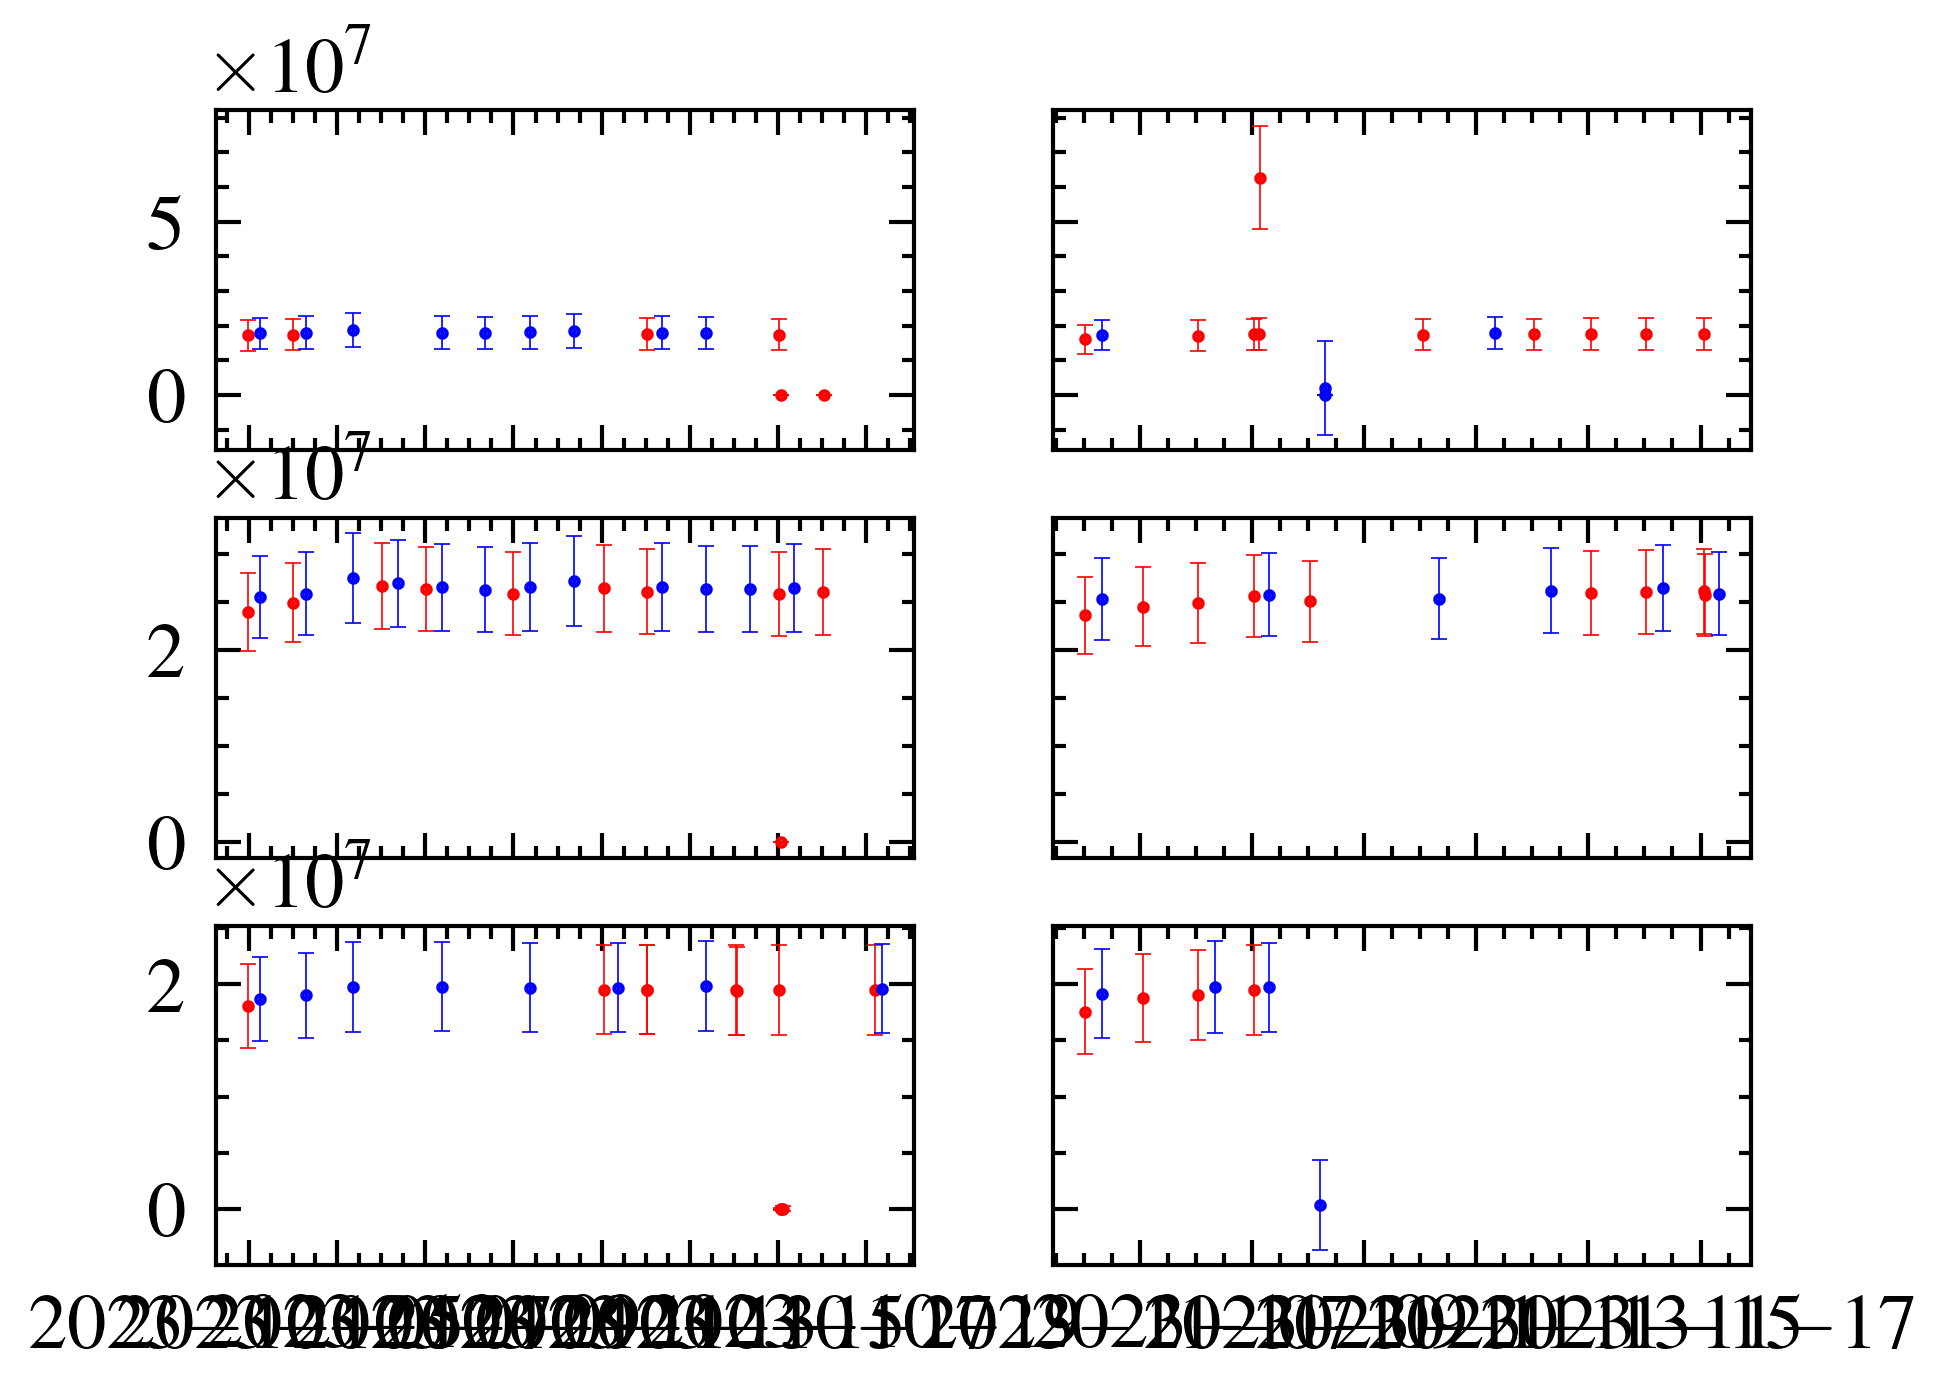

In [5]:
res_path = os.path.abspath("/cr/data01/filip/xy-calibration/results/")

set_plt_style("double tex")
fig, axes = plt.subplots(nrows=3, ncols=2, sharex="col", sharey="row")

warnings.filterwarnings("error")
warnings.simplefilter("ignore", DeprecationWarning)
measurements = [[], [], []]

for i, runlist in enumerate([runlist_oct, runlist_nov]):

    for _, row in runlist.iterrows():
        if "m25" in row.runid:
            m = 0
        if "m26" in row.runid:
            m = 1
        if "m27" in row.runid:
            m = 2
        ax = axes[m, i]
        # ax.set_yscale('log')

        cal_file = res_path + f"/out_{row.runid}.txt"

        pixel, cal_xy, sum_adc, cal_std = np.loadtxt(
            cal_file, unpack=True, usecols=[0, 1, 2, 3]
        )
        # sum_adc = remove_outliers(sum_adc)
        x_data = [row.starttime for i in range(len(sum_adc))]

        is_before_daq = row.starttime.hour < 5 or row.starttime.hour > 22

        # ax.scatter(x_data, log_sum_adc, s=3, alpha=1, c='r' if is_before_daq else 'b', marker='.')
        ax.errorbar(
            row.starttime,
            np.mean(sum_adc),
            np.std(sum_adc),
            c="r" if is_before_daq else "b",
            fmt="o",
            capsize=1,
            ms=0.5,
            elinewidth=0.2,
            capthick=0.2,
        )
        measurements[m].append(np.mean(sum_adc))


axes[0, 0].set_title("October campaign")
axes[0, 1].set_title("November campaign")
axes[2, 0].xaxis.set_major_locator(plt.MaxNLocator(3))
axes[2, 1].xaxis.set_major_locator(plt.MaxNLocator(3))
axes[0, 0].scatter([], [], c="r", label="Before DAQ", s=1)
axes[0, 0].scatter([], [], c="b", label="After DAQ", s=1)
axes[0, 1].scatter([], [], c="r", label="Before DAQ", s=1)
axes[0, 1].scatter([], [], c="b", label="After DAQ", s=1)

axes[0, 0].legend(ncol=2, loc="upper center", fontsize=3)
axes[0, 1].legend(ncol=2, loc="upper center", fontsize=3)
axes[0, 0].set_ylim(1.2e7, 2.9e7)
# axes[1, 0].set_ylim(16, 18)
# axes[2, 0].set_ylim(15, 18)

# insert measurements
# extend = lambda x: x + datetime.timedelta(hours=2)

heat1_measurements = [
    datetime.datetime(2023, 10, 13, 1, 33),
    datetime.datetime(2023, 11, 9, 6, 12),
]
heat2_measurements = [
    datetime.datetime(2023, 10, 13, 3, 9),
    datetime.datetime(2023, 11, 10, 1, 23),
    datetime.datetime(2023, 11, 17, 7, 3),
]
heat3_measurements = [
    datetime.datetime(2023, 10, 14, 1, 0),
    datetime.datetime(2023, 11, 9, 4, 59),
]

for i_m, m in enumerate(heat1_measurements):
    # axes[0][i_m].fill_between([m, extend(m)], y_max, color='k', alpha=0.4, zorder=0)
    axes[0][i_m].axvline(m, color="w", alpha=0.4, zorder=0)
    # factor = measurements[0][16 if not i_m else 36]
    # axes[0][i_m].axhline(factor, c='w', lw=0.3, ls=':')
    # print(f"'Heat #1: {'Before' if not i_m else 'After'}' : {factor},")

for i_m, m in enumerate(heat2_measurements):
    # axes[1][int(not (not i_m))].fill_between([m, extend(m)], y_max, color='k', alpha=0.4, zorder=0)
    axes[1][int(not (not i_m))].axvline(m, color="w", alpha=0.4, zorder=0)
    # factor = measurements[1][16 if i_m==0 else (37 if i_m==1 else -1)]
    # axes[1][int(not (not i_m))].axhline(factor, c='w', lw=0.3, ls=':')
    # print(f"'Heat #2: {'Before' if not i_m else 'After'}' : {factor},")


for i_m, m in enumerate(heat3_measurements):
    # axes[2][i_m].fill_between([m, extend(m)], y_max, color='k', alpha=0.4, zorder=0)
    axes[2][i_m].axvline(m, color="w", alpha=0.4, zorder=0)
    # factor = measurements[2][18 if not i_m else 37]
    # axes[2][i_m].axhline(factor, c='w', lw=0.3, ls=':')
    # print(f"'Heat #3: {'Before' if not i_m else 'After'}' : {factor},")


axes[0, 0].set_ylabel("HEAT 1")
axes[1, 0].set_ylabel("HEAT 2")
axes[2, 0].set_ylabel("HEAT 3")
plt.subplots_adjust(hspace=0.5)
# plt.savefig('calA.pdf', format='pdf')

# TRUE (NON-LOG) RESULTS! below

In [ ]:
means = {
    "Heat #1: Before": 17776664.726027396,
    "Heat #1: After": 17544910.82191781,
    "Heat #2 1: Before": 26292025.977011494,
    "Heat #2 2: Before": 26292025.977011494,
    "Heat #2 1: After": 25567121.788990825,
    "Heat #2 2: After": 25688431.19266055,
    "Heat #3: Before": 19518613.704545453,
    "Heat #3: After": 19690935.398633257,
}

In [ ]:
ratio = (
    lambda x: (means[f"{x}: After"] - means[f"{x}: Before"])
    / means[f"{x}: Before"]
    * 100
)

print(ratio("Heat #1"))
print(ratio("Heat #2 1"))
print(ratio("Heat #2 2"))
print(ratio("Heat #3"))